# 05.01.a Bare Bones Analysis with MEstimate Encoder

Goal: identify the factors that most contribute to SLAFail

Tuning Adjustments: Focus on finding the most predictive set of predictor variables


Read Prepared Data  ->  Split Data  -> Develop Pipeline  ->  Evaluate  

Split Data using sklearn.model_selection.train_test_split

Pipeline includes:

- Preprocessing variables
    - sklearn.compose.make_column_transformer 
        - Scale numeric variables: sklearn.preprocessing.StandardScaler
        - Encode categorical variables: category_encoders.MEstimateEncoder
- Selecting features
    - None
- Instantiate model
    - sklearn.linear_model.LogisticRegression
- Fit the model using training data
- Cross-validate the model with training data
    - sklearn.model_selection.cross_val_score
- Output performance measures

Evaluate involves running the pipeline with the testing data and capturing metrics





In [36]:
# Load libraries
import pandas as pd
import numpy as np
import pickle

# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.compose import make_column_transformer
import category_encoders as ce
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import make_pipeline

from sklearn.model_selection import cross_val_score

from sklearn import metrics

## Read Prepared Data

In [37]:
df = pd.read_csv("data/05.00 Incident Data.csv")
print("df.shape: " + str(df.shape))
print("df.columns: " + str(df.columns))
print("df.dtypes: \n" + str(df.dtypes))

df.shape: (35208, 10)
df.columns: Index(['Service_Component_WBS_aff', 'Urgency', 'KM_number',
       'Count_Related_Interactions', 'Count_Related_Incidents',
       'Count_Related_Changes', 'SLAFail', 'Open_Time_HourOfDay',
       'Open_Time_DayOfWeek', 'CI_TypeSubType_aff'],
      dtype='object')
df.dtypes: 
Service_Component_WBS_aff      object
Urgency                        object
KM_number                      object
Count_Related_Interactions    float64
Count_Related_Incidents       float64
Count_Related_Changes         float64
SLAFail                         int64
Open_Time_HourOfDay             int64
Open_Time_DayOfWeek            object
CI_TypeSubType_aff             object
dtype: object


#### Set X and y

In [38]:
y = df.SLAFail
y.shape

(35208,)

In [39]:
X = df.drop(['SLAFail'], axis='columns')
X.shape

(35208, 9)

Set `Open_Time_HourOfDay` for recognition as a Categorical variable

In [40]:
X.Open_Time_HourOfDay = X.Open_Time_HourOfDay.astype('object')
X.dtypes

Service_Component_WBS_aff      object
Urgency                        object
KM_number                      object
Count_Related_Interactions    float64
Count_Related_Incidents       float64
Count_Related_Changes         float64
Open_Time_HourOfDay            object
Open_Time_DayOfWeek            object
CI_TypeSubType_aff             object
dtype: object

Create a list of numeric variable column names

In [41]:
numericVars = X.select_dtypes(include=['float64']).columns
numericVars

Index(['Count_Related_Interactions', 'Count_Related_Incidents',
       'Count_Related_Changes'],
      dtype='object')

Create a list of categorical variables

In [42]:
categoricalVars = X.select_dtypes(include=['object']).columns
categoricalVars

Index(['Service_Component_WBS_aff', 'Urgency', 'KM_number',
       'Open_Time_HourOfDay', 'Open_Time_DayOfWeek', 'CI_TypeSubType_aff'],
      dtype='object')

## Split Data

Create Training and Testing Data Sets


In [43]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2020)


In [44]:
print(X_train.shape)
print(X_train.columns)

(24645, 9)
Index(['Service_Component_WBS_aff', 'Urgency', 'KM_number',
       'Count_Related_Interactions', 'Count_Related_Incidents',
       'Count_Related_Changes', 'Open_Time_HourOfDay', 'Open_Time_DayOfWeek',
       'CI_TypeSubType_aff'],
      dtype='object')


## Develop Pipeline


In [45]:
# create dictionary to store information about the pipeline and results for later reporting and review
PipeLineMetadata = { "Name" : "Bare Bones with MEstimate Encoder"}

### Encode Variables

Numeric and categorical variables require different treatment 

Set up column transformer for scaling numeric variables and encoding categorical variables



In [46]:
column_trans = make_column_transformer(
    (ce.MEstimateEncoder(), categoricalVars),
    (StandardScaler(), numericVars),
    remainder='passthrough')

Take a peek at the column transformer results

In [47]:
pd.DataFrame(column_trans.fit_transform(X_train, y_train), columns=X_train.columns).describe()

,Service_Component_WBS_aff,Urgency,KM_number,Count_Related_Interactions,Count_Related_Incidents,Count_Related_Changes,Open_Time_HourOfDay,Open_Time_DayOfWeek,CI_TypeSubType_aff
count,24645.000000,24645.000000,24645.000000,24645.000000,24645.000000,24645.000000,2.464500e+04,2.464500e+04,2.464500e+04
mean,0.299537,0.300249,0.297923,0.300221,0.300244,0.300117,-2.149281e-16,-1.561871e-15,1.298863e-15
std,0.141412,0.034505,0.208419,0.038272,0.075071,0.085922,1.000020e+00,1.000020e+00,1.000020e+00
min,0.020018,0.265514,0.006005,0.027297,0.244078,0.027297,-7.847195e-01,-7.808990e-02,-1.065131e-01
25%,0.226772,0.285793,0.101617,0.272031,0.260109,0.274758,-9.115287e-02,-7.808990e-02,-1.065131e-01
50%,0.226772,0.285793,0.278386,0.287285,0.260618,0.274758,-9.115287e-02,-7.808990e-02,-1.065131e-01
75%,0.418751,0.285793,0.470371,0.312303,0.312687,0.301969,-9.115287e-02,-7.808990e-02,-1.065131e-01
max,0.930026,0.660053,0.941689,0.710009,0.673725,0.825066,8.105615e+01,8.681520e+01,6.607034e+01


In [48]:
column_trans

ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('mestimateencoder',
                                 MEstimateEncoder(cols=None,
                                                  drop_invariant=False,
                                                  handle_missing='value',
                                                  handle_unknown='value', m=1.0,
                                                  random_state=None,
                                                  randomized=False,
                                                  return_df=True, sigma=0.05,
                                                  verbose=0),
                                 Index(['Service_Component_WBS_aff', 'Urgency', 'KM_number',
       'Open_Time_HourOfDay', 'Open_Time_DayOfWeek', 'CI_TypeSubType_aff'],
      dtype='object')),
                                ('standardscaler',
                

### Feature Selection



In [49]:
## placeholder: none for Bare Bones

### Specify Classifier (Logistic Regression)

In [50]:
classifier = LogisticRegression(solver="lbfgs")

### Compose Pipeline

In [51]:
pipe = make_pipeline(column_trans, 
                     classifier)

### Fit the Model Using the Pipeline

In [52]:
pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('mestimateencoder',
                                                  MEstimateEncoder(cols=None,
                                                                   drop_invariant=False,
                                                                   handle_missing='value',
                                                                   handle_unknown='value',
                                                                   m=1.0,
                                                                   random_state=None,
                                                                   randomized=False,
                                                                   return_df=True,
  

### Capture model  information

In [53]:
PipeLineMetadata['Column Transforms'] = list(pipe.named_steps.columntransformer.named_transformers_.keys())
PipeLineMetadata['Classifier'] = pipe.named_steps.logisticregression
PipeLineMetadata

{'Name': 'Bare Bones with MEstimate Encoder',
 'Column Transforms': ['mestimateencoder', 'standardscaler'],
 'Classifier': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False)}

In [54]:
PipeLineMetadata['Classifier - Intercept'] = pipe.named_steps.logisticregression.intercept_[0]
PipeLineMetadata['Classifier - Coefficients'] = pd.DataFrame(pipe.named_steps.logisticregression.coef_, columns=X_train.columns).transpose()
PipeLineMetadata

{'Name': 'Bare Bones with MEstimate Encoder',
 'Column Transforms': ['mestimateencoder', 'standardscaler'],
 'Classifier': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 'Classifier - Intercept': -6.152021639324596,
 'Classifier - Coefficients':                                    0
 Service_Component_WBS_aff   0.176063
 Urgency                     0.789836
 KM_number                   6.032809
 Count_Related_Interactions  4.427685
 Count_Related_Incidents     5.286315
 Count_Related_Changes       0.073164
 Open_Time_HourOfDay         0.184935
 Open_Time_DayOfWeek        -0.031457
 CI_TypeSubType_aff          0.002674}

## Cross-validate the Model with Training Data


In [55]:
PipeLineMetadata['Metrics - Cross Validation Accuracy'] = cross_val_score(pipe, X_train, y_train, cv=5, scoring="accuracy").mean()
PipeLineMetadata['Metrics - Cross Validation Accuracy']

0.7308581862446744

## Evaluate with Test Data

Get predicted classification based on the model

In [56]:
y_pred_class = pipe.predict(X_test)
y_pred_prob = pipe.predict_proba(X_test)[:,1]

In [57]:
PipeLineMetadata['Metrics - F1 score'] = metrics.f1_score(y_test, y_pred_class, average='macro')
PipeLineMetadata['Metrics - F1 score']

0.6585729428597232

Look at the resulting confusion matrix

Save True Positive (TP), True Negative (TN), False Positive(FP), and False Negative (FN) values

In [58]:
confusion = metrics.confusion_matrix(y_test, y_pred_class)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print(confusion)
print("TN: %d \t FP: %d \nFN: %d \t TP: %d " % (TN, FP, FN, TP))

[[6540  905]
 [1815 1303]]
TN: 6540 	 FP: 905 
FN: 1815 	 TP: 1303 


Capture a few classification metrics:
* Classification Accuracy: Overall, how often is the classifier correct?
* Classification Error: Overall, how often is the classifier incorrect?
* True Positive Rate  (Recall, Sensitivity): When the actual value is positive, how often is the prediction correct?
* True Negative Rate (Specificity): When the actual value is negative, how often is the prediction correct?
* False Positive Rate: When the actual value is negative, how often is the prediction incorrect?
* Precision: When a positive value is predicted, how often is the prediction correct?


In [59]:
PipeLineMetadata['Metrics - Confusion Matrix Classification Accuracy'] = metrics.accuracy_score(y_test,y_pred_class) 
PipeLineMetadata['Metrics - Confusion Matrix Classification Error'] = 1- metrics.accuracy_score(y_test,y_pred_class)
PipeLineMetadata['Metrics - Confusion Matrix True Positive Rate'] = metrics.recall_score(y_test, y_pred_class) 
PipeLineMetadata['Metrics - Confusion Matrix True Negative Rate'] =  TN / float(TN + FP)
PipeLineMetadata['Metrics - Confusion Matrix False Positive Rate'] =  FP / float(TN + FP)
PipeLineMetadata['Metrics - Confusion Matrix Precision'] = metrics.precision_score(y_test,y_pred_class)

In [60]:
PipeLineMetadata


{'Name': 'Bare Bones with MEstimate Encoder',
 'Column Transforms': ['mestimateencoder', 'standardscaler'],
 'Classifier': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 'Classifier - Intercept': -6.152021639324596,
 'Classifier - Coefficients':                                    0
 Service_Component_WBS_aff   0.176063
 Urgency                     0.789836
 KM_number                   6.032809
 Count_Related_Interactions  4.427685
 Count_Related_Incidents     5.286315
 Count_Related_Changes       0.073164
 Open_Time_HourOfDay         0.184935
 Open_Time_DayOfWeek        -0.031457
 CI_TypeSubType_aff          0.002674,
 'Metrics - Cross Validation Accuracy': 0.7308581862446744,
 'Metrics - F1 score': 0.6585

Add some ROC curve information and AUC result


In [61]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

In [62]:
PipeLineMetadata['Metrics - ROC Curve fpr array'] = fpr
PipeLineMetadata['Metrics - ROC Curve tpr array'] = tpr

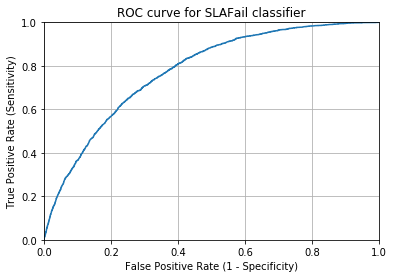

In [63]:
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for SLAFail classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

Capture resulting AUC

In [64]:
PipeLineMetadata['Metrics - AUC'] = metrics.roc_auc_score(y_test, y_pred_prob)
print("Metrics = AUC: %f " % PipeLineMetadata['Metrics - AUC']) 

Metrics = AUC: 0.776684 


## Save Details and Performance Measures for Comparison to other Models


In [65]:
PipeLineMetadata

{'Name': 'Bare Bones with MEstimate Encoder',
 'Column Transforms': ['mestimateencoder', 'standardscaler'],
 'Classifier': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 'Classifier - Intercept': -6.152021639324596,
 'Classifier - Coefficients':                                    0
 Service_Component_WBS_aff   0.176063
 Urgency                     0.789836
 KM_number                   6.032809
 Count_Related_Interactions  4.427685
 Count_Related_Incidents     5.286315
 Count_Related_Changes       0.073164
 Open_Time_HourOfDay         0.184935
 Open_Time_DayOfWeek        -0.031457
 CI_TypeSubType_aff          0.002674,
 'Metrics - Cross Validation Accuracy': 0.7308581862446744,
 'Metrics - F1 score': 0.6585

In [66]:
with open("data/05.01.a BareBones MEst.pkl",'wb') as fo:
    pickle.dump(PipeLineMetadata, fo)

In [67]:
# with open("data/05.01.a BareBones MEst", 'rb') as fi:
#    BareBonesMetadata = pickle.load(fi)